In [1]:
!pip install pytorchvideo

# 影片轉tensor

In [ ]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms.functional import center_crop

# === 設定 ===
video_dir = "/content/drive/MyDrive/Baseball Movies/釀酒人主場videos_4S/Milwaukee_Brewers_FF_videos_4S"
save_dir = os.path.join(video_dir, "tensors_x3d")
os.makedirs(save_dir, exist_ok=True)

# === 前處理參數 ===
NUM_FRAMES = 13
RESIZE_SIZE = 160
transform = Compose([
    ToTensor(),
    Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
])

# === 影片 → Tensor 函數 ===
def video_to_tensor(video_path, num_frames=NUM_FRAMES, size=RESIZE_SIZE):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        frame = center_crop(frame, size)
        frame = frame.resize((size, size))  # (H, W)
        frames.append(transform(frame))  # → (C, H, W)

    cap.release()
    if len(frames) != num_frames:
        return None  # 忽略長度不足的影片

    video_tensor = torch.stack(frames, dim=1)  # (C, T, H, W)
    return video_tensor

# === 批次處理所有影片 ===
video_list = sorted([f for f in os.listdir(video_dir) if f.endswith(".mp4")])
for video_file in tqdm(video_list, desc="Processing videos"):
    video_path = os.path.join(video_dir, video_file)
    tensor = video_to_tensor(video_path)
    if tensor is not None:
        save_path = os.path.join(save_dir, video_file.replace(".mp4", ".pt"))
        torch.save(tensor, save_path)


Processing videos: 100%|██████████| 382/382 [25:00<00:00,  3.93s/it]


# 整理成X,Y

In [19]:
import os
import torch
import pandas as pd
from tqdm import tqdm

# === 路徑設定 ===
tensor_dir = "/content/drive/MyDrive/Baseball Movies/釀酒人主場videos_4S/Milwaukee_Brewers_FF_videos_4S/tensors_x3d"
csv_path = "/content/drive/MyDrive/Baseball Movies/釀酒人主場videos_4S/Milwaukee_Brewers_FF_videos_4S/Milwaukee_Brewers_FF.csv"

# === 讀取 CSV：建立 filename → description 的對應字典 ===
df = pd.read_csv(csv_path)
label_dict = dict(zip(df["Filename"], df["description"]))  # e.g., {"pitch_0001.mp4": "strike"}

# === 讀取所有 .pt 檔案，並對應回 label ===
X = []
y = []

tensor_files = sorted([f for f in os.listdir(tensor_dir) if f.endswith(".pt")])
for pt_file in tqdm(tensor_files, desc="Loading tensors"):
    mp4_filename = pt_file.replace(".pt", ".mp4")

    if mp4_filename not in label_dict:
        print(f"⚠️ {mp4_filename} not found in CSV, skipping.")
        continue

    tensor_path = os.path.join(tensor_dir, pt_file)
    video_tensor = torch.load(tensor_path)  # (3, T, H, W)

    label = label_dict[mp4_filename]

    X.append(video_tensor)
    y.append(label)  # or use label_map[label] if you want to map to integers

print(f"✅ Loaded {len(X)} samples")


Loading tensors: 100%|██████████| 382/382 [00:10<00:00, 36.90it/s]

✅ Loaded 382 samples


# 將y做encoding

In [20]:
y = [1 if ("strike" in label.lower() or "foul" in label.lower()) else 0 for label in y]

# 現在有X,y了

# 給定X,y做對比學習

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from pytorchvideo.models.hub import x3d_xs
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

# === 固定種子 ===
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_all()

device = "cuda" if torch.cuda.is_available() else "cpu"

# === 簡單 augmentation 函數示範 ===
def augment(tensor):
    # 假設 tensor shape: [3, T, H, W]，3色彩頻道，T時間幀，H/W影像大小

    # 1. 加隨機噪音
    noise = torch.randn_like(tensor) * 0.005
    tensor = tensor + noise

    # 2. 隨機亮度調整 (每幀相同)
    brightness_factor = random.uniform(0.8, 1.2)
    tensor = tensor * brightness_factor
    tensor = torch.clamp(tensor, 0, 1)

    # 3. 隨機裁切 (保持中心附近裁切)
    _, T, H, W = tensor.shape
    crop_size = int(H * 0.9)  # 90%裁切大小
    top = random.randint(0, H - crop_size)
    left = random.randint(0, W - crop_size)
    tensor = tensor[:, :, top:top+crop_size, left:left+crop_size]
    tensor = TF.resize(tensor, [H, W])  # 裁切後resize回原大小

    # 4. 隨機水平翻轉（需注意左投右投）
    if random.random() < 0.5:
        tensor = torch.flip(tensor, dims=[3])  # 翻轉寬度維度(W)

    # 5. Temporal jittering（隨機抽取連續子序列）
    max_start = max(0, T - 10)  # 假設截10幀長度的子序列
    start_idx = random.randint(0, max_start)
    tensor = tensor[:, start_idx:start_idx+10, :, :]
    # 如果長度不夠可補齊或捨棄（視情況調整）

    return tensor

# === Dataset 定義：回傳兩個augmented版本 ===
class ContrastiveDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        x1 = augment(x)
        x2 = augment(x)
        return x1, x2, y

# 你的 X, y 已存在，直接用
dataset = ContrastiveDataset(X, y)

# === 切分訓練與驗證 ===
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# === Encoder ===
encoder = x3d_xs(pretrained=True)
encoder.blocks[-1].proj = nn.Identity()  # 移除分類頭
encoder = encoder.to(device)

# === SupCon Loss ===
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)

        anchor_dot_contrast = torch.div(torch.matmul(features, features.T), self.temperature)
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        exp_logits = torch.exp(logits) * (1 - torch.eye(features.shape[0], device=device))
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-8)

        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)
        loss = -mean_log_prob_pos.mean()
        return loss

loss_fn = SupConLoss()
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-4)
epochs = 10

train_losses, val_losses = [], []

for epoch in range(epochs):
    encoder.train()
    total_loss = 0
    for x1, x2, labels in train_loader:
        inputs = torch.cat([x1, x2], dim=0).to(device)  # batch size * 2
        labels = torch.cat([labels, labels], dim=0).to(device)

        features = encoder(inputs)
        features = F.normalize(features.view(features.size(0), -1), dim=1)

        loss = loss_fn(features, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    encoder.eval()
    val_loss = 0
    with torch.no_grad():
        for x1, x2, labels in val_loader:
            inputs = torch.cat([x1, x2], dim=0).to(device)
            labels = torch.cat([labels, labels], dim=0).to(device)

            features = encoder(inputs)
            features = F.normalize(features.view(features.size(0), -1), dim=1)
            loss = loss_fn(features, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# === Loss 曲線 ===
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Supervised Contrastive Loss")
plt.legend()
plt.grid(True)
plt.show()

# === t-SNE 視覺化 ===
all_features, all_labels = [], []
encoder.eval()
with torch.no_grad():
    for x1, x2, labels in val_loader:
        inputs = torch.cat([x1, x2], dim=0).to(device)
        features = encoder(inputs)
        features = F.normalize(features.view(features.size(0), -1), dim=1)
        all_features.append(features.cpu())
        all_labels.extend(labels)

all_features = torch.cat(all_features, dim=0).numpy()
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(all_features)

plt.figure(figsize=(6, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=all_labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE of X3D Encoder Features (Validation Set)")
plt.show()

AttributeError: module 'torch.nn.functional' has no attribute 'resize'

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


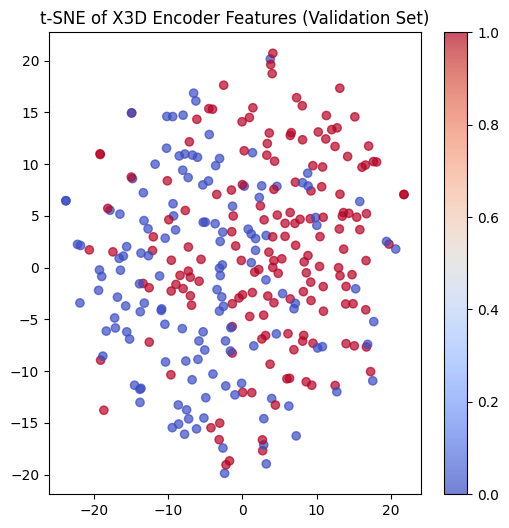

In [29]:
# === t-SNE 視覺化 ===
all_features, all_labels = [], []
encoder.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        features = encoder(inputs)
        features = F.normalize(features.view(features.size(0), -1), dim=1)
        all_features.append(features.cpu())
        all_labels.extend(labels)

all_features = torch.cat(all_features, dim=0).numpy()
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(all_features)

plt.figure(figsize=(6, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=all_labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE of X3D Encoder Features (Validation Set)")
plt.show()

# 訓練流程（含 train/val/test + 混淆矩陣）

🔧 1. 分割資料集

In [30]:
from sklearn.model_selection import train_test_split

# 先轉成 numpy array 才能 split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)


📦 2. 包成 Dataset 和 DataLoader

In [31]:
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(VideoDataset(X_train, y_train), batch_size=4, shuffle=True)
val_loader   = DataLoader(VideoDataset(X_val, y_val),     batch_size=4, shuffle=False)
test_loader  = DataLoader(VideoDataset(X_test, y_test),   batch_size=4, shuffle=False)


🧠 3. 建立模型與訓練設定

In [37]:
import torch.nn as nn
from pytorchvideo.models.hub import x3d_xs
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
encoder.blocks[-1].proj = nn.Linear(2048, 2).to(device)  # 改成二分類
model = encoder.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


🏃 4. 訓練＋驗證迴圈

In [38]:
from tqdm.notebook import tqdm
import gc
def evaluate(model, dataloader):
    model.eval()
    correct, total, loss_total = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return loss_total / len(dataloader), correct / total

# === Training Loop ===
num_epochs = 5
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        gc.collect()

    train_acc = correct / total
    val_loss, val_acc = evaluate(model, val_loader)
    gc.collect()
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 48.2876 | Train Acc: 0.4708 | Val Loss: 0.6809 | Val Acc: 0.5072


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 45.1930 | Train Acc: 0.6679 | Val Loss: 0.6859 | Val Acc: 0.4928


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 39.4780 | Train Acc: 0.7555 | Val Loss: 0.6726 | Val Acc: 0.5797


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 31.4433 | Train Acc: 0.8942 | Val Loss: 0.6725 | Val Acc: 0.6087


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 28.2800 | Train Acc: 0.9124 | Val Loss: 0.6747 | Val Acc: 0.5942


📊 5. 測試集混淆矩陣

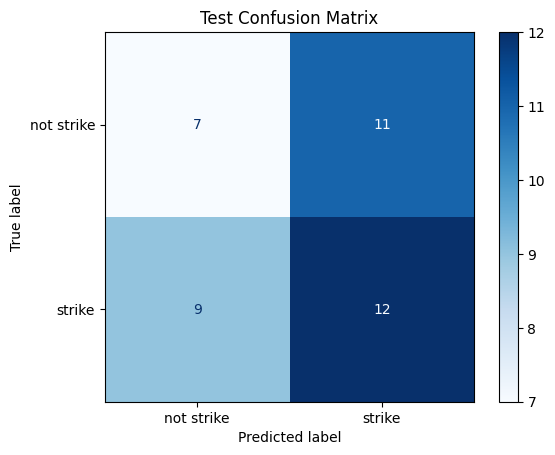

Classification Report:
               precision    recall  f1-score   support

  not strike       0.44      0.39      0.41        18
      strike       0.52      0.57      0.55        21

    accuracy                           0.49        39
   macro avg       0.48      0.48      0.48        39
weighted avg       0.48      0.49      0.48        39



In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 推論 test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# 畫混淆矩陣
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not strike", "strike"])
disp.plot(cmap='Blues')
plt.title("Test Confusion Matrix")
plt.show()

# 繪製分類報告
from sklearn.metrics import classification_report

# 產生分類報告（文字形式）
report = classification_report(y_true, y_pred, target_names=["not strike", "strike"])
print("Classification Report:\n", report)
